<a href="https://colab.research.google.com/github/wushidiguo/transformer/blob/main/%E5%8A%A8%E6%89%8B%E5%AE%9E%E7%8E%B0transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **参考：**
#### [Attention is All You Need](https://arxiv.org/abs/1706.03762)
#### [The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)


In [41]:
import time
import copy
import math

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [43]:
class Embedding(nn.Module):
    '''
    Embedding将输入序列中的元素（取值范围0~vocab），映射为d_model维的向量
    '''
    def __init__(self, d_model, vocab):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(
            num_embeddings=vocab,
            embedding_dim=d_model,
        )
    
    def forward(self, x):
        # 遵照原文，乘上sqrt(d_model)，目的大概是调整embedding的取值范围
        return self.embedding(x) * math.sqrt(self.d_model)

def test_embedding():
    input = torch.LongTensor([[4, 0, 3, 9], [2, 7, 3, 1]])
    embedding = Embedding(d_model=3, vocab=10)
    print(embedding(input))

test_embedding()

tensor([[[-0.3978,  0.6604, -0.2213],
         [-0.9540, -1.3541, -0.0943],
         [-1.6784, -0.8629,  0.0114],
         [-1.2424, -1.3073,  0.5360]],

        [[-1.2561,  2.0146, -2.3181],
         [ 2.0068,  1.9864, -0.3942],
         [-1.6784, -0.8629,  0.0114],
         [ 0.8009,  0.8205,  0.0665]]], grad_fn=<MulBackward0>)


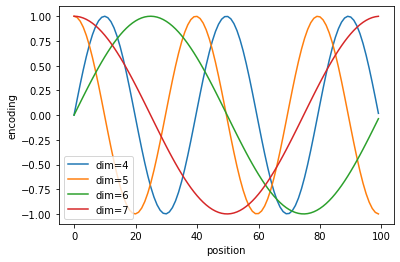

In [44]:
class PositionEncoder(nn.Module):
    '''
    原文中指出选择这种编码的原因是:对于固定的偏移k，
    PE_{pos+k}可以表示为PE_pos的线性方程，因此模型比较容易学习到位置关系：
    PE_{pos+k} = sin(pos+k) = cos(pos)sin(k)+sin(pos)cos(k) = w*PE_pos+b
    '''
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros((max_len, d_model))
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = 10000 ** - (torch.arange(0, d_model, 2) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 当d_model为奇数时，div_term的维数会不同
        div_term = 10000 ** - ((torch.arange(1, d_model, 2) - 1) / d_model)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe.unsqueeze_(0)
        pe.requires_grad_(False)
        '''
        通过register_buffer()注册过的张量，会自动成为模型中的参数，
        随着模型移动（gpu/cpu）移动，但是不会被optimizer更新。
        '''
        self.register_buffer("pe", pe)

    def forward(self, x):
        assert x.size(1) <= self.max_len, "sequence size exceeds max_len"
        return self.dropout(x + self.pe[:, : x.size(1)])

def test_position_encoder():
    b, p, d = 1, 100, 20
    input = torch.zeros(b, p, d)
    p_encoder = PositionEncoder(d_model=d, max_len=p, dropout=0)
    output = p_encoder(input)
    plt.plot(range(p), output[0, :, 4:8])
    plt.xlabel("position")
    plt.ylabel("encoding")
    plt.legend([f"dim={i}" for i in range(4, 8)])
    plt.show()

test_position_encoder()

In [45]:
class Generator(nn.Module):
    '''
    因为我们想使用CrossEntropyLoss，所以Generator只进行了一次映射，没有进行softmax
    '''
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return self.proj(x)

def test_generator():
    b, p, d, v = 3, 4, 5, 6
    input = torch.rand(b, p, d)
    gen = Generator(d_model=d, vocab=v)
    print(gen(input))

test_generator()

tensor([[[ 0.4563, -0.5086,  0.8042, -0.1075, -0.1331,  0.6192],
         [ 0.4542, -0.3907,  0.7209, -0.2246,  0.0198,  0.7991],
         [ 0.0171, -0.3372,  0.8326, -0.0878, -0.2145,  0.7202],
         [ 0.3981, -0.6575,  0.7996, -0.0570, -0.1691,  0.3962]],

        [[ 0.8466, -0.4888,  0.4357, -0.4022,  0.1374,  0.6095],
         [ 0.2124, -0.3324,  0.6024, -0.3253, -0.1296,  0.7765],
         [ 0.0687, -0.4215,  0.8454,  0.0164, -0.2495,  0.5010],
         [ 0.3121, -0.3864,  0.8076, -0.1553, -0.1339,  0.7896]],

        [[ 0.6105, -0.4767,  0.5632, -0.4169,  0.1048,  0.8183],
         [ 0.2104, -0.4318,  0.6649, -0.2698, -0.0725,  0.7126],
         [ 0.4098, -0.3183,  0.5453, -0.3107, -0.0421,  0.7062],
         [-0.0037, -0.1827,  0.6986, -0.2610, -0.1841,  0.9194]]],
       grad_fn=<ViewBackward0>)


In [46]:
class MultiHeadAttention(nn.Module):
    '''
    transformer中使用的MultiHeadAttention有三种，encoder中的MultiHeadAttention不使用mask，
    qkv的输入相同；decoder第一层的MultiHeadAttention，需要mask，qkv相同；decoder第二层的
    MultiHeadAttention，不需要mask，q来自上一层的输出，kv来自encoder。
    '''
    def __init__(self, d_model, nheads, mask=False, dropout=0.1):
        assert not d_model % nheads, "d_model must be divisible by nheads"
        super().__init__()
        self.d_model = d_model
        self.nheads = nheads
        self.d_k = d_model // nheads
        self.mask = mask
        self.dropout = nn.Dropout(p=dropout)

        self.proj_q = nn.Linear(d_model, d_model)
        self.proj_k = nn.Linear(d_model, d_model)
        self.proj_v = nn.Linear(d_model, d_model)

        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x, memory=None):
        '''
        einsum是一种更直觉的矩阵乘法计算方式，只要维数对了，不需要考虑其他细节。
        '''
        if memory is None:
            memory = x
        b = x.size(0)
        Q = self.proj_q(x).view(b, -1, self.nheads, self.d_k)
        K = self.proj_k(memory).view(b, -1, self.nheads, self.d_k)
        V = self.proj_v(memory).view(b, -1, self.nheads, self.d_k)

        score = torch.einsum("nphk,nqhk->nhpq", Q, K) / math.sqrt(self.d_k)
        if self.mask:
            mask = torch.triu_indices(score.size(2), score.size(3), offset=1)
            score[:, :, mask[0], mask[1]] = float("-inf")
        score = F.softmax(score, dim=-1)
        score = self.dropout(score)
        attn = torch.einsum("nhpq,nqhk->nphk", score, V).reshape(b, -1, self.d_model)
        return self.linear(attn)

def test_attention():
    b, p, d = 3, 4, 10
    input = torch.rand(b, p, d)
    attn = MultiHeadAttention(d_model=d, nheads=2, mask=True)
    print(attn(input))

test_attention()

tensor([[[-0.0289,  0.1752, -0.7373, -0.4860, -0.1653,  0.1868, -0.0219,
           0.1652,  0.0032,  0.5626],
         [ 0.0618,  0.1954, -0.6991, -0.4166, -0.2889,  0.0455, -0.0426,
           0.2508, -0.0224,  0.5357],
         [-0.0866,  0.0695, -0.4764, -0.3687, -0.2928,  0.0044, -0.1674,
           0.2257, -0.0129,  0.4242],
         [-0.0253,  0.1770, -0.6471, -0.4083, -0.2893, -0.0089, -0.0739,
           0.2516, -0.0143,  0.5152]],

        [[-0.0860,  0.1512, -0.7053, -0.4220, -0.2262,  0.1495,  0.0012,
           0.2685,  0.0460,  0.4804],
         [-0.1137, -0.0081, -0.5219, -0.2802, -0.1499,  0.2465, -0.0569,
           0.1717,  0.0480,  0.4378],
         [-0.0288,  0.1469, -0.6508, -0.3641, -0.1962,  0.1861, -0.0313,
           0.2202,  0.0260,  0.4978],
         [ 0.0501,  0.1384, -0.6884, -0.3295, -0.1966,  0.2512, -0.0206,
           0.2438,  0.0489,  0.4885]],

        [[ 0.1918,  0.1890, -0.7678, -0.3764, -0.3051,  0.1928,  0.0198,
           0.3452,  0.0031,  0.5980

In [47]:
class FeedForward(nn.Module):
    '''
    FeedForward就是简单的两个线性层。
    '''
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = nn.Dropout(p=dropout)

        self.proj_1 = nn.Linear(d_model, d_ff)
        self.proj_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.dropout(self.proj_2(F.relu(self.proj_1(x))))

def test_ff():
    b, p, d = 3, 4, 5
    input = torch.rand(b, p, d)
    ff = FeedForward(d_model=d, d_ff=4*d)
    print(ff(input))

test_ff()

tensor([[[-0.0122, -0.2999, -0.0766, -0.0173, -0.1680],
         [ 0.0304, -0.4230, -0.1913, -0.1030, -0.2430],
         [ 0.1073, -0.1550, -0.0000,  0.0463, -0.2975],
         [-0.0082, -0.2685, -0.0000,  0.0009, -0.1884]],

        [[ 0.0208, -0.2159, -0.0958,  0.0946, -0.3094],
         [ 0.0631, -0.2841, -0.1690, -0.0466, -0.1524],
         [ 0.0523, -0.2948, -0.0000, -0.0554, -0.1961],
         [ 0.0872, -0.1136, -0.1922,  0.0692, -0.3200]],

        [[-0.0576, -0.1937, -0.0689,  0.0519, -0.2258],
         [ 0.0867, -0.2542, -0.2138, -0.0487, -0.0000],
         [ 0.0800, -0.2332, -0.1088,  0.0027, -0.2030],
         [ 0.1487, -0.2138, -0.0748, -0.0264, -0.1065]]],
       grad_fn=<MulBackward0>)


In [48]:
class Encoder(nn.Module):
    def __init__(self, d_model, nheads, d_ff, dropout=0.1, n_encoders=6):
        super().__init__()
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_encoders):
            self.layers.append(MultiHeadAttention(d_model=d_model, nheads=nheads, mask=False, dropout=dropout))
            self.norms.append(nn.LayerNorm(d_model))
            self.layers.append(FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout))
            self.norms.append(nn.LayerNorm(d_model))

    def forward(self, x):
        for layer, norm in zip(self.layers, self.norms):
            x = norm(layer(x) + x)
        return x

def test_encoder():
    b, p, d = 3, 4, 10
    input = torch.rand(b, p, d)
    encoder = Encoder(d_model=d, nheads=5, d_ff=4*d)
    print(encoder(input))

test_encoder()

tensor([[[-0.6312,  1.2855, -0.4243, -0.6125, -0.8742,  0.6170,  1.9405,
          -1.5475,  0.2939, -0.0471],
         [-1.7635,  1.1758,  0.2069, -0.2388, -1.2191,  1.2011,  1.3329,
           0.0768,  0.0603, -0.8322],
         [-2.0246,  1.0131, -0.5588,  1.2058, -1.0026,  0.9570,  0.8475,
          -0.5822,  0.3168, -0.1721],
         [-1.9181,  0.6815,  0.1971,  0.5688, -0.9706,  1.2515,  1.4426,
          -0.8464,  0.0266, -0.4330]],

        [[-1.6044,  1.2757,  0.1655, -0.0250, -1.2930, -0.1317,  1.8830,
          -0.6738,  0.2065,  0.1972],
         [-1.5140,  1.6543, -0.2218, -0.5236, -0.9353,  0.3513,  1.4976,
          -0.9500,  0.7072, -0.0657],
         [-1.4308,  1.1688,  0.0646, -0.5580, -1.1546, -0.5616,  0.7791,
          -0.8131,  0.9245,  1.5811],
         [-1.7355,  1.1668,  0.4079, -0.3437, -0.4356, -0.3249,  2.1126,
          -0.7063,  0.1229, -0.2642]],

        [[-1.7791,  0.8593, -0.5584, -0.2662, -0.1380,  0.2067,  1.9447,
          -0.2340,  0.9351, -0.9701

In [49]:
class Decoder(nn.Module):
    def __init__(self, d_model, nheads, d_ff, dropout=0.1, n_decoders=6):
        super().__init__()
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_decoders):
            self.layers.append(MultiHeadAttention(d_model=d_model, nheads=nheads, mask=True, dropout=dropout))
            self.norms.append(nn.LayerNorm(d_model))
            self.layers.append(MultiHeadAttention(d_model=d_model, nheads=nheads, mask=False, dropout=dropout))
            self.norms.append(nn.LayerNorm(d_model))
            self.layers.append(FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout))
            self.norms.append(nn.LayerNorm(d_model))

    def forward(self, x, memory):
        for layer, norm in zip(self.layers, self.norms):
            if isinstance(layer, MultiHeadAttention) and not layer.mask:
                x = norm(layer(x, memory) + x) 
            else:
                x = norm(layer(x) + x)
        return x

def test_decoder():
    b, p, d = 3, 4, 10
    input = torch.rand(b, p, d)
    memory = torch.rand(b, p, d)
    decoder = Decoder(d_model=d, nheads=5, d_ff=4*d)
    print(decoder(input, memory))

test_decoder()


tensor([[[ 0.6046,  0.4506, -0.7507, -0.6060, -0.4274,  1.0453, -2.1426,
          -0.3925,  1.2072,  1.0116],
         [ 1.3422, -0.7168,  1.2618, -0.9963, -0.4307,  0.1468, -1.5309,
          -0.5802,  1.4874,  0.0168],
         [ 1.4369, -0.2086,  1.6235, -1.0556, -0.2124,  0.1933, -1.9872,
          -0.1670,  0.2641,  0.1130],
         [ 0.9500, -0.5288,  2.3101, -1.0309,  0.1430,  0.4206, -1.3205,
          -0.2479, -0.0529, -0.6427]],

        [[ 0.8625, -0.2591,  0.6975, -1.2537,  0.7166,  0.1196, -1.8577,
          -0.9533,  0.5250,  1.4026],
         [ 1.5531,  0.2993,  0.4738, -0.7993,  0.4851,  0.8294, -2.2635,
           0.3519, -0.3385, -0.5913],
         [ 1.2687, -0.2253,  1.5283, -1.5823,  0.6410,  0.0891, -1.7059,
          -0.2280,  0.3267, -0.1123],
         [ 1.3265, -0.2244,  2.1211, -1.2637,  0.1236,  0.0977, -1.2448,
           0.0493, -0.3672, -0.6182]],

        [[ 1.3117, -0.8581,  1.8180, -0.2817, -0.2384, -0.2165, -1.7251,
          -0.6754,  0.7850,  0.0805

In [50]:
class Transformer(nn.Module):
    def __init__(
        self, 
        d_model=512, 
        nheads=8, 
        n_encoders=6,
        n_decoders=6,
        d_ff=2048, 
        vocab=1000,
        dropout=0.1, 
        max_len=512,
    ):
        '''
        参数：
        d_model：向量长度
        nheads：multiheadattention的head数
        n_encoders：encoder的层数
        n_decoders：decoder的层数 
        n_ff：FeedForward的隐藏层维度
        dropout：全局的dropout率
        vocab：使用的字典长度，用于embedding，默认encoder和decoder使用相同的embedding
        max_len：输入的最大序列长度，用于postion_encoding
        '''
        super().__init__()
        self.d_model = d_model
        self.embedding = Embedding(d_model=d_model, vocab=vocab)
        self.position_encoder = PositionEncoder(d_model=d_model, max_len=max_len, dropout=dropout)
        self.encoder = Encoder(d_model=d_model, nheads=nheads, d_ff=d_ff, dropout=dropout, n_encoders=n_encoders)
        self.decoder = Decoder(d_model=d_model, nheads=nheads, d_ff=d_ff, dropout=dropout, n_decoders=n_decoders)
        self.generator = Generator(d_model=d_model, vocab=vocab)
        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() >= 2:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        return self.decode(tgt, self.encode(src))

    def encode(self, src):
        x = self.embedding(src)
        x = self.position_encoder(x)
        return self.encoder(x)

    def decode(self, tgt, memory):
        y = self.embedding(tgt)
        y = self.position_encoder(y)
        y = self.decoder(y, memory)
        return self.generator(y)
    
def test_transformer():
    src = torch.randint(low=0, high=10, size=(3, 10))
    tgt = torch.randint(low=0, high=10, size=(3, 10))
    transformer = Transformer(vocab=10)
    print(transformer(src, tgt))

test_transformer()

tensor([[[-0.8774, -1.3694, -1.7076,  0.7393, -1.1089,  2.3121, -1.0089,
           0.0197,  1.1095, -1.5722],
         [-1.4151, -1.8768, -2.4163,  1.2379, -0.5062,  1.8712, -1.4279,
          -0.0414,  1.1322, -2.0253],
         [-1.9513, -2.4766, -1.2778,  1.1809, -1.0611,  1.4543, -1.8356,
          -0.8095,  0.5623, -2.1747],
         [-1.6403, -1.9153, -1.3794,  0.3410, -0.4637,  1.4636, -0.6857,
          -0.8097,  1.1822, -1.7644],
         [-1.4482, -2.1283, -1.3600,  1.4208, -0.2813,  2.3073, -0.7141,
          -0.7636,  0.7361, -1.2999],
         [-1.9770, -2.4397, -1.2139,  1.3574, -1.1137,  1.8146, -0.8395,
          -0.4587,  0.9917, -1.6917],
         [-2.0998, -2.2411, -1.3255,  1.2213, -0.3785,  2.0556, -1.8274,
          -0.8051,  0.4458, -2.0182],
         [-2.0489, -1.9751, -1.2616,  1.0129, -0.5309,  1.9758, -1.3730,
          -0.1486,  0.9511, -1.9019],
         [-1.4468, -2.0780, -1.0906,  1.4244, -0.4043,  2.2915, -1.8463,
          -0.2984,  0.8606, -1.8415],
 

## **测试**
进行一个小测试，让transformer学习copy输入的随机序列到输出，当然transformer并不知道任务的目标就是copy，而是要自己发现规律。

In [51]:
vocab = 10 # 字典取值0~9，其中0作为序列起始标志
length = 15 # 输入序列的长度
model = Transformer(vocab=vocab, n_encoders=2, n_decoders=2, d_ff=2048, max_len=100, nheads=2, d_model=512).to(device)

In [52]:
class Batch:
    def __init__(self, data):
        self.src = data[:, 1:]
        self.tgt = data[:, :-1]  # 输入decoder的output，不包含最后一个position
        self.tgt_y = self.src # 原始target，不包含起始符

def data_gen(batch_size, nbatches):
    for i in range(nbatches):
        data = torch.randint(1, vocab, size=(batch_size, length), requires_grad=False)
        data[:, 0] = 0
        yield Batch(data)

def test_gen():
    gen = data_gen(5, 1)
    batch = next(gen)
    print(batch.src, "\n", batch.tgt, "\n", batch.tgt_y)

test_gen()

tensor([[6, 6, 1, 9, 8, 6, 9, 7, 9, 2, 8, 7, 5, 2],
        [8, 8, 9, 1, 6, 3, 7, 2, 1, 9, 5, 6, 5, 8],
        [3, 3, 9, 5, 4, 5, 5, 2, 8, 8, 4, 2, 2, 8],
        [6, 2, 4, 6, 8, 9, 7, 7, 4, 1, 2, 8, 5, 8],
        [6, 4, 5, 5, 7, 9, 8, 2, 6, 7, 1, 2, 3, 6]]) 
 tensor([[0, 6, 6, 1, 9, 8, 6, 9, 7, 9, 2, 8, 7, 5],
        [0, 8, 8, 9, 1, 6, 3, 7, 2, 1, 9, 5, 6, 5],
        [0, 3, 3, 9, 5, 4, 5, 5, 2, 8, 8, 4, 2, 2],
        [0, 6, 2, 4, 6, 8, 9, 7, 7, 4, 1, 2, 8, 5],
        [0, 6, 4, 5, 5, 7, 9, 8, 2, 6, 7, 1, 2, 3]]) 
 tensor([[6, 6, 1, 9, 8, 6, 9, 7, 9, 2, 8, 7, 5, 2],
        [8, 8, 9, 1, 6, 3, 7, 2, 1, 9, 5, 6, 5, 8],
        [3, 3, 9, 5, 4, 5, 5, 2, 8, 8, 4, 2, 2, 8],
        [6, 2, 4, 6, 8, 9, 7, 7, 4, 1, 2, 8, 5, 8],
        [6, 4, 5, 5, 7, 9, 8, 2, 6, 7, 1, 2, 3, 6]])


In [53]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

optimizer = optim.Adam(model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9)

lr_scheduler = optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: rate(
        step, model_size=model.d_model, factor=1.0, warmup=400
    )
)

loss_fn = nn.CrossEntropyLoss()

In [54]:
def train(model, train_data):
    model.train()
    total_loss = 0.
    log_interval = 5
    start_time = time.time()

    for i, batch in enumerate(train_data):
        output = model(batch.src.to(device), batch.tgt.to(device))
        loss = loss_fn(output.reshape(-1, vocab), batch.tgt_y.to(device).reshape(-1))  # 需要先把output变成(N*t, C)，才能输入损失函数
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % log_interval == 0 and i > 0:
            lr = lr_scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| {i:5d}/{nbatches:5d} batches | '
                  f'lr {lr:5.2e} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f}')
            total_loss = 0
            start_time = time.time()
        lr_scheduler.step()

def evaluate(model, eval_data):
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i, batch in enumerate(eval_data):
            output = model(batch.src.to(device), batch.tgt.to(device))
            loss = loss_fn(output.reshape(-1, vocab), batch.tgt_y.to(device).reshape(-1))
            total_loss += loss.item()
    return total_loss / (i + 1)

In [60]:
nbatches = 20   # 每个epoch的batch数
batch_size = 80 # 每个batch的数据量
val_nbatches = 5    # 每个epoch测试用的batch数

best_val_loss = float('inf')
epochs = 20
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, data_gen(batch_size, nbatches))
    print("-" * 65)
    val_loss = evaluate(model, data_gen(val_nbatches, batch_size))
    elapsed = time.time() - epoch_start_time
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f}')
    print('-' * 65)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model).cpu()

|     5/   20 batches | lr 7.79e-04 | ms/batch 61.59 | loss  0.09
|    10/   20 batches | lr 7.76e-04 | ms/batch 40.16 | loss  0.08
|    15/   20 batches | lr 7.74e-04 | ms/batch 39.59 | loss  0.06
-----------------------------------------------------------------
| end of epoch   1 | time:  1.22s | valid loss  0.03
-----------------------------------------------------------------
|     5/   20 batches | lr 7.69e-04 | ms/batch 47.93 | loss  0.17
|    10/   20 batches | lr 7.67e-04 | ms/batch 40.22 | loss  0.09
|    15/   20 batches | lr 7.65e-04 | ms/batch 40.47 | loss  0.11
-----------------------------------------------------------------
| end of epoch   2 | time:  1.17s | valid loss  0.02
-----------------------------------------------------------------
|     5/   20 batches | lr 7.60e-04 | ms/batch 46.19 | loss  0.09
|    10/   20 batches | lr 7.58e-04 | ms/batch 40.47 | loss  0.07
|    15/   20 batches | lr 7.56e-04 | ms/batch 39.58 | loss  0.14
------------------------------------

In [62]:
def greedy_decode(model, src, max_len, start_symbol):
    '''
    训练好的模型用auto-regressive的方式生成序列
    '''
    memory = model.encode(src)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len):
        out = model.decode(ys, memory)[:, -1]
        _, next_word = torch.max(out, dim=1)
        next_word = next_word[0].item()
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
        print(f"第{i+1}次生成:", ys)
    return ys[:, 1:]

src = torch.randint(1, vocab, size=(1, length))
out = greedy_decode(best_model, src, length, 0)
print("src is: ", src[0])
print("out is: ", out[0])

第1次生成: tensor([[0, 7]])
第2次生成: tensor([[0, 7, 9]])
第3次生成: tensor([[0, 7, 9, 1]])
第4次生成: tensor([[0, 7, 9, 1, 6]])
第5次生成: tensor([[0, 7, 9, 1, 6, 4]])
第6次生成: tensor([[0, 7, 9, 1, 6, 4, 9]])
第7次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8]])
第8次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4]])
第9次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1]])
第10次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9]])
第11次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9]])
第12次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5]])
第13次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5, 5]])
第14次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5, 5, 4]])
第15次生成: tensor([[0, 7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5, 5, 4, 8]])
src is:  tensor([7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5, 5, 4, 8])
out is:  tensor([7, 9, 1, 6, 4, 9, 8, 4, 1, 9, 9, 5, 5, 4, 8])
